In [37]:
from datetime import date

import pandas as pd
from src.data.preprocessing import cacl_monthly_avg_kpi
from src.utils.variables import pharma_companies, global_economy_indicators

In [2]:
raw_dir = "./data/raw/"
kpi= "Adj Close"

tickers = list(pharma_companies.keys()) + list(global_economy_indicators.keys())

monthly_abj_close = pd.DataFrame()
for ticker in tickers:
    ticker_df = pd.read_csv(f"{raw_dir}{ticker}.csv", index_col=0)
    ticker_df.index = pd.to_datetime(ticker_df.index)
    ticker_df  = cacl_monthly_avg_kpi(ticker_df, kpi)
    ticker_df.name = ticker
    
    monthly_abj_close = pd.concat([monthly_abj_close, ticker_df], axis=1)
    
monthly_abj_close.index = pd.to_datetime(monthly_abj_close.index, format="%Y-%m").to_period()

In [119]:
covid_period = pd.to_datetime(date(2020, 3, 1)).to_period(freq="M")
monthly_abj_close = monthly_abj_close.loc[monthly_abj_close.index < covid_period, :]
X = monthly_abj_close.iloc[:-6, :]
y = monthly_abj_close.iloc[-6:, :]


In [ ]:
forecaster = MultiplexForecaster(forecasters=[
    ("ets", AutoETS()),
    ("theta", ThetaForecaster()),
    ("naive", NaiveForecaster())])  

cv = ExpandingWindowSplitter(step_length=12) 
 
gscv = ForecastingGridSearchCV(
    cv=cv,
    param_grid={"selected_forecaster":["ets", "theta", "naive"]},
    forecaster=forecaster)  
gscv.fit(y)  
ForecastingGridSearchCV(...)

In [132]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.varmax import VARMAX
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import (
   ForecastingGridSearchCV,
   ExpandingWindowSplitter)

cv = ExpandingWindowSplitter(step_length=6) 

forecaster = MultiplexForecaster(forecasters=[
    ("autoets", AutoETS()),
    ("arima", ARIMA()),
    ("sarimax", SARIMAX()),
    ("varmax", VARMAX())
    ])  

gscv = ForecastingGridSearchCV(
    cv=cv,
    param_grid= {"selected_forecaster":["autoets","arima", "sarimax", "varmax"]},
    forecaster= forecaster)

gscv.fit(X["GSK"], X=X[global_economy_indicators.keys()]) 

c:\Users\joanp\anaconda3\envs\causal_inference_ts\Lib\site-packages\sktime\forecasting\model_selection\_tune.py:198: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(
c:\Users\joanp\anaconda3\envs\causal_inference_ts\Lib\site-packages\sktime\utils\parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster MultiplexForecaster failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff NaT, and len(y_train)=10.
                The score will be set to nan.
                Failed forecaster with parameters: MultiplexForecaster(forecasters=[('autoets', AutoETS()), ('arima', ARIMA()),
                                 ('sarimax', SARIMAX()), ('varm

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(step_length=6),
                        forecaster=MultiplexForecaster(forecasters=[('autoets',
                                                                     AutoETS()),
                                                                    ('arima',
                                                                     ARIMA()),
                                                                    ('sarimax',
                                                                     SARIMAX()),
                                                                    ('varmax',
                                                                     VARMAX())]),
                        param_grid={'selected_forecaster': ['autoets', 'arima',
                                                            'sarimax',
                                                            'varmax']})

In [136]:
gscv.best_params_

{'selected_forecaster': 'arima'}

In [137]:
# Get the best model
best_model = gscv.best_forecaster_

# Forecast with the best model
y_pred = best_model.predict(fh=np.arange(len(y)),
                            X=X[global_economy_indicators.keys()])

<Axes: >

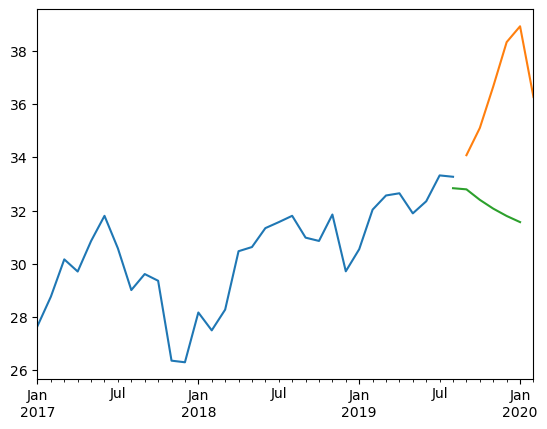

: 

In [138]:
X["GSK"].plot()
y["GSK"].plot()
y_pred.plot()